# Processamento imagens

Aplicar uma transformação na imagem usando máscaras (filtros). O procedimento deve ser paralelizado como diferentes processos. Para iso, usaremos a lib "multiprocessing" e o método Process. 

# Transformação usando vetores

\begin{equation*}
    L = \left[ \frac{1}{\sqrt{2}},  \frac{1}{\sqrt{2}} \right]; H = \left[ \frac{1}{\sqrt{2}},  \frac{-1}{\sqrt{2}} \right]
\end{equation*}

<img src="https://image.ibb.co/j7ygL0/photo-2018-10-31-23-54-42.jpg" width="300" alt="explanation" >

```
entrada → saída


      1 → LL
     /
L --+
     \
      2 → LH
      
      3 → HL
     /
H --+
     \
      4 → HH
```

### Procedimento 1:

1) Aplicar o vetor L (produto interno/escalar) entre pares sucessivos das linhas da matriz original sem stride (overlap) para gerar um nova matriz de tamanho $\left(N, \frac{N}{2}\right)$.

2) Nessa matriz agora percorrer as colunas aplicando L em pares sucessivos das colunas. A saída deve ser uma nova matriz chamada 'LL' de tamanho $\left(\frac{N}{2}, \frac{N}{2} \right)$.

### Procedimento 2:

1) Aplicar o vetor L (produto interno) entre pares sucessivos das linhas da matriz original sem stride (overlap) para gerar um nova matriz de tamanho $\left(N, \frac{N}{2}\right)$. 

2) Nessa matriz agora percorrer as colunas aplicando H em pares sucessivos das colunas. A sáida deve ser uma nova matriz chamda 'LH' de tamanho $\left(\frac{N}{2}, \frac{N}{2} \right)$.

### Procedimento 3:

1) Aplicar o vetor H (produto interno) entre pares sucessivos das linhas da matriz original sem stride (overlap) para gerar um nova matriz de tamanho $\left(N, \frac{N}{2}\right)$. 

2) Nessa matriz agora percorrer as colunas aplicando L em pares sucessivos das colunas. A sáida deve ser uma nova matriz chamda 'HL' de tamanho $\left(\frac{N}{2}, \frac{N}{2} \right)$.

### Procedimento 4:

1) Aplicar o vetor H (produto interno) entre pares sucessivos das linhas da matriz original sem stride (overlap) para gerar um nova matriz de tamanho $\left(N, \frac{N}{2} \right)$. 

2) Nessa matriz agora percorrer as colunas aplicando H em pares sucessivos das colunas. A sáida deve ser uma nova matriz chamda 'HH' de tamanho $\left(\frac{N}{2}, \frac{N}{2} \right)$.

### Método adotado:
- Criar dois processos para a aplicação da parte 1 que é comum aos dois primeiros e dois últimos procedimentos
- Cada um desses dois processos criarão outros 2 que realizarão a aplicação da parte 2 de cada um dos quatros procedimento
- Para extrair os resultados _(as imagens com os filtros aplicados)_ da memória dos processos filhos, foi utilizado um `Dict` com o `server process Manager`

<img src="https://image.ibb.co/dNWMnf/schema.png" width="400px" alt="esquema">

In [1]:
from multiprocessing import Process
import numpy as np
import matplotlib.pyplot as plt
import pywt ## PyWavelets
import pywt.data
from matplotlib.image import imread
from math import sqrt

## load image
original = pywt.data.camera()
N = original.shape[0]
L = [1/sqrt(2), 1/sqrt(2)]
H = [1/sqrt(2), -1/sqrt(2)]


def aplicar_vetor_nas_colunas(v, m):
  """
  [etapa 1 do procedimento]
  Dada uma matriz de tamanho N par,
  gerar uma nova matriz (NxN/2) com o produto interno de um vetor v em cada par de elementos
  em colunas consecutivas em todas as linhas da matriz.
  """
  N, M = m.shape
  m_transformada = np.empty([N, M//2])
  
  for i in range(0, N):
    for j in range(0, M, 2):
      vetor_colunas = [ m[i][j], m[i][j+1] ]
      m_transformada[i][j//2] = np.dot(v, vetor_colunas)

  return m_transformada


def aplicar_vetor_nas_linhas(v, m):
  """
  [etapa 2 do procedimento]
  """
  return aplicar_vetor_nas_colunas(v, m.transpose()).transpose()


## Realiza o procedimento 1
def gerar_matriz_LL(matriz_filtro_L):
  return aplicar_vetor_nas_linhas(L, matriz_filtro_L)

## Realiza o procedimento 2
def gerar_matriz_LH(matriz_filtro_L):
  return aplicar_vetor_nas_linhas(H, matriz_filtro_L)

## Realiza o procedimento 3
def gerar_matriz_HL(matriz_filtro_H):
  return aplicar_vetor_nas_linhas(L, matriz_filtro_H)

## Realiza o procedimento 4
def gerar_matriz_HH(matriz_filtro_H):
  return aplicar_vetor_nas_linhas(H, matriz_filtro_H)



def plotar_imagens(LL, LH, HL, HH):
  titles = ['original', 'LL', 'LH', 'HL', 'HH']
  fig = plt.figure(figsize=(12, 3))
  for i, a in enumerate([original, LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(a, interpolation='nearest', cmap=plt.cm.gray)
    ax.set_title(titles[i] + ' ' + str(a.shape), fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

  fig.tight_layout()
  plt.show()

###  versão sequencial (1 processo)

L começou
L terminou
H começou
H terminou


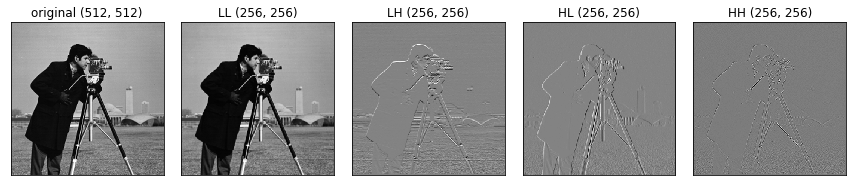

CPU times: user 2.58 s, sys: 492 ms, total: 3.07 s
Wall time: 2.62 s


In [7]:
def __sequencial__():
  print('L começou')
  ## aplicar o produto interno do vetor L sobre a matriz original
  matriz_filtro_L = aplicar_vetor_nas_colunas(L, original)
  
  LL = gerar_matriz_LL(matriz_filtro_L)
  LH = gerar_matriz_LH(matriz_filtro_L)

  print('L terminou')

  print('H começou')
  ## aplicar o produto interno do vetor H sobre a matriz original
  matriz_filtro_H = aplicar_vetor_nas_colunas(H, original)
  
  HL = gerar_matriz_HL(matriz_filtro_H)
  HH = gerar_matriz_HH(matriz_filtro_H)

  print('H terminou')

  plotar_imagens(LL, LH, HL, HH)


%time __sequencial__()

###  versão paralela (multiprocessos)

L começou
H começou
H terminou
L terminou


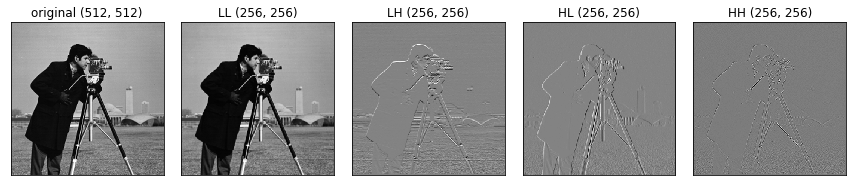

CPU times: user 300 ms, sys: 20 ms, total: 320 ms
Wall time: 1.2 s


In [6]:
import multiprocessing as mp

def __paralelo__():
  
  def _gerar_matriz_LL(matriz_filtro_L):
    resultados['LL'] = gerar_matriz_LL(matriz_filtro_L)

  def _gerar_matriz_LH(matriz_filtro_L):
    resultados['LH'] = aplicar_vetor_nas_linhas(H, matriz_filtro_L)

  def _gerar_matriz_HL(matriz_filtro_H):
    resultados['HL'] = aplicar_vetor_nas_linhas(L, matriz_filtro_H)

  def _gerar_matriz_HH(matriz_filtro_H):
    resultados['HH'] = aplicar_vetor_nas_linhas(H, matriz_filtro_H)


  def gerar_L():
    print('L começou')
    matriz_filtro_L = aplicar_vetor_nas_colunas(L, original)
    
    p3 = mp.Process(target=_gerar_matriz_LL, args=(matriz_filtro_L,))
    p4 = mp.Process(target=_gerar_matriz_LH, args=(matriz_filtro_L,))
    
    p3.start()
    p4.start()
    
    p3.join()
    p4.join()
    print('L terminou')

  def gerar_H():
    print('H começou')
    matriz_filtro_H = aplicar_vetor_nas_colunas(H, original)
    
    p5 = mp.Process(target=_gerar_matriz_HL, args=(matriz_filtro_H,))
    p6 = mp.Process(target=_gerar_matriz_HH, args=(matriz_filtro_H,))
    
    p5.start()
    p6.start()
    
    p5.join()
    p6.join()
    print('H terminou')
    

  manager = mp.Manager()
  resultados = manager.dict()

  p1 = mp.Process(target=gerar_L)
  p2 = mp.Process(target=gerar_H)
  
  p1.daemon = False
  p2.daemon = False
  
  p1.start()
  p2.start()
  
  p1.join()
  p2.join()

  LL = resultados['LL']
  LH = resultados['LH']
  HL = resultados['HL']
  HH = resultados['HH']

  plotar_imagens(LL, LH, HL, HH)

 
%time __paralelo__()